In [1]:
import trainExplainer
import trainExplainer_trainSplit
import sweepExplainerBACommunity
import importlib
import datasetLoader
import evaluation
import torch
import explainer
import networks
import wandb

importlib.reload(trainExplainer)
importlib.reload(datasetLoader)

<module 'datasetLoader' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\datasetLoader.py'>

In [ ]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_AUC"},
    "parameters": {
        'epochs': {
            'values': [20]
            },
        'tT': {
            'values': [1.0, 5.0]
            },
        'size_reg': {
            'values': [0.1]
            },
        'entropy_reg': {
            'values': [0.1]
            },
        'lr_mlp':{
            'values': [0.003, 0.0001]
            },
        'seed':{
            'values': [74, 75]
            },
    },
}   

In [ ]:
'L2_reg': {
            'values': [0.0, 0.01, 0.1, 1.0]
            },

In [13]:
sweep_id = wandb.sweep(sweep_config, project="Sweep-BA-Community")

Create sweep with ID: 5gl59efq
Sweep URL: https://wandb.ai/tristan-schulz2001-tu-dortmund/Sweep-BA-Community/sweeps/5gl59efq


In [2]:
dataset="Tree-Grid"

In [14]:
wandb.agent(sweep_id, sweepExplainerBACommunity.trainExplainer)

wandb: Agent Starting Run: jin78i4p with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.0032345266081392765
BinaryAUROC: 0.43387553884459745
roc_auc_score: 0.4338755388445975
Epoch 2, Loss: 0.0016237245872616768
BinaryAUROC: 0.5552115819874663
roc_auc_score: 0.5552115819874663
Epoch 3, Loss: 0.0006860779249109328
BinaryAUROC: 0.6466876847733298
roc_auc_score: 0.6466876847733298
Epoch 4, Loss: 0.0005509041948243976
BinaryAUROC: 0.6995109669470829
roc_auc_score: 0.6995109669470829
Epoch 5, Loss: 0.0005439601955004036
BinaryAUROC: 0.7326157313993382
roc_auc_score: 0.7326157313993383
Epoch 6, Loss: 0.000543707690667361
BinaryAUROC: 0.7543118425705602
roc_auc_score: 0.7543118425705603
Epoch 7, Loss: 0.000543667993042618
BinaryAUROC: 0.7692951505782268
roc_auc_score: 0.7692951505782268
Epoch 8, Loss: 0.0005436642095446587
BinaryAUROC: 0.7801415879414086
roc_auc_score: 0.7801415879414088
Epoch 9, Loss: 0.0005436631035991013
BinaryAUROC: 0.7882811615215142
roc_auc_score: 0.7882811615215142
Epoch 10, Loss: 0.0005436629289761186
BinaryAUROC: 0.7945878506603347
roc_

train/Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.81985
val/temperature,1


wandb: Agent Starting Run: rvnlgfvp with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.003216293640434742
BinaryAUROC: 0.433371498927778
roc_auc_score: 0.43337149892777804


wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 2, Loss: 0.0017038247315213084
BinaryAUROC: 0.5562437529812599
roc_auc_score: 0.55624375298126
Epoch 3, Loss: 0.0007443859940394759
BinaryAUROC: 0.6494591805157334
roc_auc_score: 0.6494591805157333
Epoch 4, Loss: 0.0005649106460623443
BinaryAUROC: 0.7032011505761596
roc_auc_score: 0.7032011505761596
Epoch 5, Loss: 0.0005473082419484854
BinaryAUROC: 0.7365727264002048
roc_auc_score: 0.7365727264002048
Epoch 6, Loss: 0.0005452214390970767
BinaryAUROC: 0.7581373029529447
roc_auc_score: 0.7581373029529448
Epoch 7, Loss: 0.000544574751984328
BinaryAUROC: 0.7729230469955233
roc_auc_score: 0.7729230469955233
Epoch 8, Loss: 0.0005444597918540239
BinaryAUROC: 0.7835577276476887
roc_auc_score: 0.7835577276476886
Epoch 9, Loss: 0.0005445287679322064
BinaryAUROC: 0.7915138732556722
roc_auc_score: 0.7915138732556722
Epoch 10, Loss: 0.0005446326686069369
BinaryAUROC: 0.7976624878091003
roc_auc_score: 0.7976624878091004
Epoch 11, Loss: 0.0005449119489639997
BinaryAUROC: 0.8025455020021613
roc_a

train/Loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00057
val/mean_AUC,0.82271
val/temperature,5


wandb: Agent Starting Run: stc6uhto with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.00539151206612587
BinaryAUROC: 0.4589296977241715
roc_auc_score: 0.4589296977241715
Epoch 2, Loss: 0.0021850529592484236
BinaryAUROC: 0.5743324162416994
roc_auc_score: 0.5743324162416994
Epoch 3, Loss: 0.0006793084903620183
BinaryAUROC: 0.654225702604667
roc_auc_score: 0.654225702604667
Epoch 4, Loss: 0.0005494001670740545
BinaryAUROC: 0.7004771329377307
roc_auc_score: 0.7004771329377307
Epoch 5, Loss: 0.0005439454107545316
BinaryAUROC: 0.7300292497326518
roc_auc_score: 0.7300292497326518
Epoch 6, Loss: 0.0005437053041532636
BinaryAUROC: 0.7500604863770666
roc_auc_score: 0.7500604863770666
Epoch 7, Loss: 0.0005436671781353652
BinaryAUROC: 0.7641016713759892
roc_auc_score: 0.7641016713759892
Epoch 8, Loss: 0.000543663976714015
BinaryAUROC: 0.7744076034817411
roc_auc_score: 0.7744076034817411
Epoch 9, Loss: 0.0005436631035991013
BinaryAUROC: 0.7822096956079444
roc_auc_score: 0.7822096956079443
Epoch 10, Loss: 0.0005436629289761186
BinaryAUROC: 0.7882826298318291
roc_auc_

train/Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.8129
val/temperature,1


wandb: Agent Starting Run: 1l2fq0sq with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.0053803459741175175
BinaryAUROC: 0.45995072900527306
roc_auc_score: 0.459950729005273
Epoch 2, Loss: 0.0022673397324979305
BinaryAUROC: 0.5763753024121926
roc_auc_score: 0.5763753024121925
Epoch 3, Loss: 0.0007371027604676783
BinaryAUROC: 0.6572508218854998
roc_auc_score: 0.6572508218854998
Epoch 4, Loss: 0.0005626946804113686
BinaryAUROC: 0.7039026668942777
roc_auc_score: 0.7039026668942777
Epoch 5, Loss: 0.0005473706987686455
BinaryAUROC: 0.7335922995321696
roc_auc_score: 0.7335922995321696
Epoch 6, Loss: 0.000545320101082325
BinaryAUROC: 0.753475828853194
roc_auc_score: 0.753475828853194
Epoch 7, Loss: 0.0005446600844152272
BinaryAUROC: 0.7673555808865641
roc_auc_score: 0.7673555808865641
Epoch 8, Loss: 0.0005445765564218163
BinaryAUROC: 0.7774993595330105
roc_auc_score: 0.7774993595330106
Epoch 9, Loss: 0.0005446880823001266
BinaryAUROC: 0.7851616768884764
roc_auc_score: 0.7851616768884764
Epoch 10, Loss: 0.0005448484444059432
BinaryAUROC: 0.7911279332013547
roc_au

train/Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00058
val/mean_AUC,0.81604
val/temperature,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tcibs3ch with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.004108228255063295
BinaryAUROC: 0.39204897871217514
roc_auc_score: 0.39204897871217514
Epoch 2, Loss: 0.003964926581829786
BinaryAUROC: 0.47055059872744565
roc_auc_score: 0.4705505987274456
Epoch 3, Loss: 0.0035459641367197037
BinaryAUROC: 0.5958808313529228
roc_auc_score: 0.5958808313529228
Epoch 4, Loss: 0.0026100659742951393
BinaryAUROC: 0.6998019116259137
roc_auc_score: 0.6998019116259137
Epoch 5, Loss: 0.003025736892595887
BinaryAUROC: 0.7250781308221745
roc_auc_score: 0.7250781308221745
Epoch 6, Loss: 0.001687275362201035
BinaryAUROC: 0.7491788488007176
roc_auc_score: 0.7491788488007176
Epoch 7, Loss: 0.0015827128663659096
BinaryAUROC: 0.769250377432342
roc_auc_score: 0.769250377432342
Epoch 8, Loss: 0.001365460455417633
BinaryAUROC: 0.7900011728228558
roc_auc_score: 0.7900011728228558
Epoch 9, Loss: 0.001243118429556489
BinaryAUROC: 0.8090489182723777
roc_auc_score: 0.8090489182723777
Epoch 10, Loss: 0.001002432545647025
BinaryAUROC: 0.8247993453892132
roc_auc_s

train/Loss,██▇▅▆▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val/mean_AUC,▁▂▄▆▆▆▇▇▇▇▇█████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00055
val/mean_AUC,0.8706
val/temperature,1


wandb: Agent Starting Run: 9seun1ar with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.004109452478587627
BinaryAUROC: 0.38824903674337985
roc_auc_score: 0.38824903674337985
Epoch 2, Loss: 0.00395246222615242
BinaryAUROC: 0.4627413179411308
roc_auc_score: 0.4627413179411308
Epoch 3, Loss: 0.0035049773287028074
BinaryAUROC: 0.5859621234008439
roc_auc_score: 0.5859621234008439
Epoch 4, Loss: 0.0026742122136056423
BinaryAUROC: 0.6753718040322846
roc_auc_score: 0.6753718040322846
Epoch 5, Loss: 0.0022665115538984537
BinaryAUROC: 0.7147430744913845
roc_auc_score: 0.7147430744913845
Epoch 6, Loss: 0.001599057111889124
BinaryAUROC: 0.7465688002666073
roc_auc_score: 0.7465688002666073
Epoch 7, Loss: 0.001461609499529004
BinaryAUROC: 0.762937569437649
roc_auc_score: 0.762937569437649
Epoch 8, Loss: 0.0010516431648284197
BinaryAUROC: 0.7745836571294511
roc_auc_score: 0.7745836571294511
Epoch 9, Loss: 0.0009209769195877016
BinaryAUROC: 0.7798051242621413
roc_auc_score: 0.7798051242621413
Epoch 10, Loss: 0.0008760493947193027
BinaryAUROC: 0.7795483428319296
roc_auc_

train/Loss,██▇▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▂▄▆▇▇▇█████▇▇▇█████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00071
val/mean_AUC,0.80101
val/temperature,5


wandb: Agent Starting Run: c2z16tlh with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.008161339908838272
BinaryAUROC: 0.5042555926822276
roc_auc_score: 0.5042555926822276
Epoch 2, Loss: 0.006999051198363304
BinaryAUROC: 0.6373644276662193
roc_auc_score: 0.6373644276662193
Epoch 3, Loss: 0.006315100006759167
BinaryAUROC: 0.6853822127086888
roc_auc_score: 0.6853822127086888
Epoch 4, Loss: 0.003026291960850358
BinaryAUROC: 0.737733035918124
roc_auc_score: 0.737733035918124
Epoch 5, Loss: 0.0022196888457983732
BinaryAUROC: 0.7725332643078566
roc_auc_score: 0.7725332643078566
Epoch 6, Loss: 0.001604540040716529
BinaryAUROC: 0.7917750772022536
roc_auc_score: 0.7917750772022537
Epoch 7, Loss: 0.0013904622755944729
BinaryAUROC: 0.8070490558613237
roc_auc_score: 0.8070490558613238
Epoch 8, Loss: 0.000881947111338377
BinaryAUROC: 0.818566374206381
roc_auc_score: 0.8185663742063809
Epoch 9, Loss: 0.0007303666207008064
BinaryAUROC: 0.8269289400580275
roc_auc_score: 0.8269289400580276
Epoch 10, Loss: 0.0005946729797869921
BinaryAUROC: 0.8325196324439699
roc_auc_scor

train/Loss,█▇▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▄▅▆▇▇▇▇████████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.84368
val/temperature,1


wandb: Agent Starting Run: cgq11fh6 with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.008154131472110748
BinaryAUROC: 0.505307534635006
roc_auc_score: 0.505307534635006
Epoch 2, Loss: 0.006923781707882881
BinaryAUROC: 0.64135037656057
roc_auc_score: 0.64135037656057
Epoch 3, Loss: 0.006344808731228113
BinaryAUROC: 0.6954826557087382
roc_auc_score: 0.6954826557087381
Epoch 4, Loss: 0.003118046559393406
BinaryAUROC: 0.7333741189816922
roc_auc_score: 0.7333741189816921
Epoch 5, Loss: 0.0023317669983953238
BinaryAUROC: 0.7643992174198724
roc_auc_score: 0.7643992174198725
Epoch 6, Loss: 0.001703934627585113
BinaryAUROC: 0.7863745188666978
roc_auc_score: 0.7863745188666978
Epoch 7, Loss: 0.0014224323676899076
BinaryAUROC: 0.8019515966399098
roc_auc_score: 0.8019515966399098
Epoch 8, Loss: 0.0010585866402834654
BinaryAUROC: 0.8136269040412473
roc_auc_score: 0.8136269040412472
Epoch 9, Loss: 0.0009123565396293998
BinaryAUROC: 0.8222953539715423
roc_auc_score: 0.8222953539715423
Epoch 10, Loss: 0.0007531504961661994
BinaryAUROC: 0.8286587542890982
roc_auc_score:

train/Loss,█▇▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▄▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.0006
val/mean_AUC,0.85064
val/temperature,5


wandb: Agent Starting Run: hk9uapzb with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.0032345266081392765
BinaryAUROC: 0.3359258629813008
roc_auc_score: 0.3359258629813008
Epoch 2, Loss: 0.003129426157101989
BinaryAUROC: 0.33930102414212826
roc_auc_score: 0.33930102414212826
Epoch 3, Loss: 0.002972222166135907
BinaryAUROC: 0.3425429621930118
roc_auc_score: 0.3425429621930118
Epoch 4, Loss: 0.0028407443314790726
BinaryAUROC: 0.34617894688843914
roc_auc_score: 0.34617894688843914
Epoch 5, Loss: 0.0027699165511876345
BinaryAUROC: 0.3497602775365132
roc_auc_score: 0.3497602775365132
Epoch 6, Loss: 0.002891896991059184
BinaryAUROC: 0.3538389333757638
roc_auc_score: 0.3538389333757637
Epoch 7, Loss: 0.00270372093655169
BinaryAUROC: 0.3579897304414564
roc_auc_score: 0.35798973044145643
Epoch 8, Loss: 0.0026835983153432608
BinaryAUROC: 0.3621505666774419
roc_auc_score: 0.3621505666774419
Epoch 9, Loss: 0.002510660793632269
BinaryAUROC: 0.3663054495930839
roc_auc_score: 0.3663054495930839
Epoch 10, Loss: 0.0027031749486923218
BinaryAUROC: 0.3704881295428508
roc_

train/Loss,█▇▆▆▅▆▅▅▄▅▄▄▃▃▃▂▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00204
val/mean_AUC,0.41029
val/temperature,1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: enywe115 with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.003216293640434742
BinaryAUROC: 0.335909167001
roc_auc_score: 0.335909167001
Epoch 2, Loss: 0.0031235346104949713
BinaryAUROC: 0.3390705472376005
roc_auc_score: 0.33907054723760044
Epoch 3, Loss: 0.0029537612572312355
BinaryAUROC: 0.3421486155789055
roc_auc_score: 0.3421486155789055
Epoch 4, Loss: 0.0028494459111243486
BinaryAUROC: 0.3454624732944104
roc_auc_score: 0.3454624732944104
Epoch 5, Loss: 0.002808711025863886
BinaryAUROC: 0.34871199945615283
roc_auc_score: 0.34871199945615283
Epoch 6, Loss: 0.002869462128728628
BinaryAUROC: 0.3524404155430447
roc_auc_score: 0.3524404155430447
Epoch 7, Loss: 0.002807118697091937
BinaryAUROC: 0.35624314974305116
roc_auc_score: 0.35624314974305116
Epoch 8, Loss: 0.0028114933520555496
BinaryAUROC: 0.36002083771992793
roc_auc_score: 0.360020837719928
Epoch 9, Loss: 0.0026897152420133352
BinaryAUROC: 0.3638403601873825
roc_auc_score: 0.3638403601873825
Epoch 10, Loss: 0.002758863614872098
BinaryAUROC: 0.36765133810032946
roc_auc_sc

train/Loss,█▇▅▄▃▄▃▃▂▃▂▂▁▂▃▂▂▂▃▃
val/mean_AUC,▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00276
val/mean_AUC,0.39855
val/temperature,5


wandb: Agent Starting Run: 24dwk1x6 with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.00539151206612587
BinaryAUROC: 0.3368979814202876
roc_auc_score: 0.3368979814202876
Epoch 2, Loss: 0.005280038807541132
BinaryAUROC: 0.34115837107216873
roc_auc_score: 0.34115837107216873
Epoch 3, Loss: 0.005020395386964083
BinaryAUROC: 0.3453829278774007
roc_auc_score: 0.3453829278774007
Epoch 4, Loss: 0.004846352618187666
BinaryAUROC: 0.34972204275335256
roc_auc_score: 0.34972204275335256
Epoch 5, Loss: 0.004686747677624226
BinaryAUROC: 0.35404102849445407
roc_auc_score: 0.35404102849445407
Epoch 6, Loss: 0.004734495654702187
BinaryAUROC: 0.3585308782208998
roc_auc_score: 0.35853087822089974
Epoch 7, Loss: 0.0045208376832306385
BinaryAUROC: 0.3630518406334079
roc_auc_score: 0.3630518406334079
Epoch 8, Loss: 0.004438256844878197
BinaryAUROC: 0.36756159030284347
roc_auc_score: 0.3675615903028435
Epoch 9, Loss: 0.004216517321765423
BinaryAUROC: 0.3720497947747193
roc_auc_score: 0.3720497947747193
Epoch 10, Loss: 0.004343646112829447
BinaryAUROC: 0.3765258589813578
roc_a

wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 16, Loss: 0.003613959765061736
BinaryAUROC: 0.40278700709000037
roc_auc_score: 0.40278700709000037
Epoch 17, Loss: 0.003438354702666402
BinaryAUROC: 0.40709393177294384
roc_auc_score: 0.40709393177294384
Epoch 18, Loss: 0.0033871103078126907
BinaryAUROC: 0.4113878917830225
roc_auc_score: 0.4113878917830225
Epoch 19, Loss: 0.0031932243146002293
BinaryAUROC: 0.415671672375411
roc_auc_score: 0.415671672375411
Epoch 20, Loss: 0.00317577738314867
BinaryAUROC: 0.41994084100568757
roc_auc_score: 0.4199408410056876


train/Loss,██▇▆▆▆▅▅▄▅▄▄▃▃▃▂▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00318
val/mean_AUC,0.41994
val/temperature,1


wandb: Agent Starting Run: 9qjunmbu with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.0053803459741175175
BinaryAUROC: 0.336940116243763
roc_auc_score: 0.3369401162437631
Epoch 2, Loss: 0.005283877719193697
BinaryAUROC: 0.3411475099649278
roc_auc_score: 0.3411475099649278
Epoch 3, Loss: 0.005025455728173256
BinaryAUROC: 0.3453136648472842
roc_auc_score: 0.3453136648472842
Epoch 4, Loss: 0.004890588112175465
BinaryAUROC: 0.34958127288009844
roc_auc_score: 0.34958127288009844
Epoch 5, Loss: 0.004773154389113188
BinaryAUROC: 0.3538298053775504
roc_auc_score: 0.35382980537755043
Epoch 6, Loss: 0.0047958181239664555
BinaryAUROC: 0.3582218056576429
roc_auc_score: 0.3582218056576429
Epoch 7, Loss: 0.004707111045718193
BinaryAUROC: 0.3626749987111482
roc_auc_score: 0.3626749987111482
Epoch 8, Loss: 0.0046644266694784164
BinaryAUROC: 0.3671297074538819
roc_auc_score: 0.3671297074538819
Epoch 9, Loss: 0.004501421935856342
BinaryAUROC: 0.3715728347409558
roc_auc_score: 0.3715728347409558
Epoch 10, Loss: 0.004545486066490412
BinaryAUROC: 0.3759797781995523
roc_auc_

train/Loss,█▇▆▅▄▄▄▃▂▂▂▂▁▁▂▁▁▁▂▂
val/mean_AUC,▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00443
val/mean_AUC,0.41596
val/temperature,5


wandb: Agent Starting Run: byaiy253 with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.004108228255063295
BinaryAUROC: 0.3787707398446848
roc_auc_score: 0.3787707398446848
Epoch 2, Loss: 0.00411083223298192
BinaryAUROC: 0.3791722609488289
roc_auc_score: 0.37917226094882883
Epoch 3, Loss: 0.004110998939722776
BinaryAUROC: 0.3798242580910072
roc_auc_score: 0.3798242580910072
Epoch 4, Loss: 0.0041167838498950005
BinaryAUROC: 0.38079718088151715
roc_auc_score: 0.38079718088151715
Epoch 5, Loss: 0.004107069224119186
BinaryAUROC: 0.38185617429902574
roc_auc_score: 0.38185617429902574
Epoch 6, Loss: 0.00410518329590559
BinaryAUROC: 0.3826251397324785
roc_auc_score: 0.3826251397324785
Epoch 7, Loss: 0.00410484941676259
BinaryAUROC: 0.3837059836944708
roc_auc_score: 0.3837059836944708
Epoch 8, Loss: 0.004093961790204048
BinaryAUROC: 0.3852420024007494
roc_auc_score: 0.38524200240074946
Epoch 9, Loss: 0.004087192006409168
BinaryAUROC: 0.38704012859564924
roc_auc_score: 0.3870401285956493
Epoch 10, Loss: 0.004088564310222864
BinaryAUROC: 0.3889746810638446
roc_auc_

train/Loss,████▇▇▇▇▆▆▇▆▆▅▅▄▃▃▂▁
val/mean_AUC,▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▆▆▇▇█
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00399
val/mean_AUC,0.41746
val/temperature,1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5oz2n1oa with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.004109452478587627
BinaryAUROC: 0.3786601081924172
roc_auc_score: 0.3786601081924172
Epoch 2, Loss: 0.004113176837563515
BinaryAUROC: 0.3788231892465544
roc_auc_score: 0.3788231892465544
Epoch 3, Loss: 0.0041137514635920525
BinaryAUROC: 0.37922496352268387
roc_auc_score: 0.37922496352268387
Epoch 4, Loss: 0.0041192444041371346
BinaryAUROC: 0.3797937306653267
roc_auc_score: 0.3797937306653267
Epoch 5, Loss: 0.004110192414373159
BinaryAUROC: 0.38058143547639073
roc_auc_score: 0.3805814354763908
Epoch 6, Loss: 0.004104823339730501
BinaryAUROC: 0.38156620699195265
roc_auc_score: 0.38156620699195265
Epoch 7, Loss: 0.004098304081708193
BinaryAUROC: 0.383137584973747
roc_auc_score: 0.383137584973747
Epoch 8, Loss: 0.0040802620351314545
BinaryAUROC: 0.38511418157694544
roc_auc_score: 0.38511418157694544
Epoch 9, Loss: 0.004063802771270275
BinaryAUROC: 0.38752507837103034
roc_auc_score: 0.3875250783710304
Epoch 10, Loss: 0.004053617361932993
BinaryAUROC: 0.3902855577167174
roc_

train/Loss,███████▇▇▇▇▆▆▅▅▄▃▃▂▁
val/mean_AUC,▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇█
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00368
val/mean_AUC,0.42628
val/temperature,5


wandb: Agent Starting Run: k0av9c6f with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.008161339908838272
BinaryAUROC: 0.38161938088426267
roc_auc_score: 0.3816193808842627
Epoch 2, Loss: 0.008167821913957596
BinaryAUROC: 0.38467254259583195
roc_auc_score: 0.3846725425958319
Epoch 3, Loss: 0.008160127326846123
BinaryAUROC: 0.38773182418061225
roc_auc_score: 0.38773182418061225
Epoch 4, Loss: 0.00817104708403349
BinaryAUROC: 0.390882903354889
roc_auc_score: 0.390882903354889
Epoch 5, Loss: 0.008146453648805618
BinaryAUROC: 0.3941303184663019
roc_auc_score: 0.394130318466302
Epoch 6, Loss: 0.008134879171848297
BinaryAUROC: 0.3974604022969934
roc_auc_score: 0.3974604022969934
Epoch 7, Loss: 0.008125469088554382
BinaryAUROC: 0.4009527689343308
roc_auc_score: 0.40095276893433085
Epoch 8, Loss: 0.008094346150755882
BinaryAUROC: 0.4044941827751494
roc_auc_score: 0.40449418277514937
Epoch 9, Loss: 0.008071930147707462
BinaryAUROC: 0.40821094277732606
roc_auc_score: 0.4082109427773261
Epoch 10, Loss: 0.008070976473391056
BinaryAUROC: 0.4120403308135026
roc_auc_sc

train/Loss,█████▇▇▇▇▇▇▆▆▅▅▄▃▃▂▁
val/mean_AUC,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00769
val/mean_AUC,0.45705
val/temperature,1


wandb: Agent Starting Run: ity1buvn with config:
wandb: 	entropy_reg: 1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.008154131472110748
BinaryAUROC: 0.3816435838063329
roc_auc_score: 0.3816435838063329
Epoch 2, Loss: 0.008150788955390453
BinaryAUROC: 0.3847706935377556
roc_auc_score: 0.3847706935377556
Epoch 3, Loss: 0.0081273652613163
BinaryAUROC: 0.3879210879704656
roc_auc_score: 0.3879210879704656
Epoch 4, Loss: 0.008118896745145321
BinaryAUROC: 0.3911593427468301
roc_auc_score: 0.3911593427468301
Epoch 5, Loss: 0.008074420504271984
BinaryAUROC: 0.39452701920200395
roc_auc_score: 0.39452701920200395
Epoch 6, Loss: 0.008022966794669628
BinaryAUROC: 0.39793678462774773
roc_auc_score: 0.39793678462774773
Epoch 7, Loss: 0.007967174053192139
BinaryAUROC: 0.40143208149101495
roc_auc_score: 0.40143208149101495
Epoch 8, Loss: 0.007884491235017776
BinaryAUROC: 0.4050400946060749
roc_auc_score: 0.4050400946060749
Epoch 9, Loss: 0.007807710207998753
BinaryAUROC: 0.40881095747606716
roc_auc_score: 0.40881095747606716
Epoch 10, Loss: 0.007738722022622824
BinaryAUROC: 0.4127026436967478
roc_auc

wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 16, Loss: 0.006983392406255007
BinaryAUROC: 0.43905183025597255
roc_auc_score: 0.4390518302559725
Epoch 17, Loss: 0.006827556062489748
BinaryAUROC: 0.44393717938652927
roc_auc_score: 0.4439371793865293
Epoch 18, Loss: 0.0067732073366642
BinaryAUROC: 0.44867991566223203
roc_auc_score: 0.4486799156622321
Epoch 19, Loss: 0.006596935447305441
BinaryAUROC: 0.45349257732816817
roc_auc_score: 0.45349257732816817
Epoch 20, Loss: 0.006489061284810305
BinaryAUROC: 0.45834112525103166
roc_auc_score: 0.45834112525103166


train/Loss,█████▇▇▇▇▆▆▅▅▄▄▃▂▂▁▁
val/mean_AUC,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00649
val/mean_AUC,0.45834
val/temperature,5


wandb: Agent Starting Run: x8alu2o9 with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.002915486693382263
BinaryAUROC: 0.43396046002427546
roc_auc_score: 0.43396046002427546
Epoch 2, Loss: 0.0014313855208456516
BinaryAUROC: 0.5559938802977018
roc_auc_score: 0.5559938802977018
Epoch 3, Loss: 0.0006283532129600644
BinaryAUROC: 0.6462218451228244
roc_auc_score: 0.6462218451228245
Epoch 4, Loss: 0.0005475857178680599
BinaryAUROC: 0.6986469638459232
roc_auc_score: 0.6986469638459231
Epoch 5, Loss: 0.0005438043735921383
BinaryAUROC: 0.7318636565485332
roc_auc_score: 0.7318636565485332
Epoch 6, Loss: 0.0005436865612864494
BinaryAUROC: 0.7540379284311062
roc_auc_score: 0.7540379284311063
Epoch 7, Loss: 0.0005436656647361815
BinaryAUROC: 0.7694113682915916
roc_auc_score: 0.7694113682915916
Epoch 8, Loss: 0.0005436635692603886
BinaryAUROC: 0.7805950099565653
roc_auc_score: 0.7805950099565653
Epoch 9, Loss: 0.0005436629871837795
BinaryAUROC: 0.78900968512831
roc_auc_score: 0.78900968512831
Epoch 10, Loss: 0.0005436626961454749
BinaryAUROC: 0.7955302865007082
roc_au

train/Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.82168
val/temperature,1


wandb: Agent Starting Run: bz002ojn with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.0028771928045898676
BinaryAUROC: 0.4344418217916337
roc_auc_score: 0.4344418217916337
Epoch 2, Loss: 0.0014711315743625164
BinaryAUROC: 0.5579231962332873
roc_auc_score: 0.5579231962332873
Epoch 3, Loss: 0.0006585413357242942
BinaryAUROC: 0.6496788225458234
roc_auc_score: 0.6496788225458234
Epoch 4, Loss: 0.0005542724393308163
BinaryAUROC: 0.7025864891077919
roc_auc_score: 0.7025864891077919
Epoch 5, Loss: 0.0005454545607790351
BinaryAUROC: 0.7358764361506421
roc_auc_score: 0.7358764361506421
Epoch 6, Loss: 0.0005444788839668036
BinaryAUROC: 0.7578040124982063
roc_auc_score: 0.7578040124982064
Epoch 7, Loss: 0.0005441561224870384
BinaryAUROC: 0.7729269268343996
roc_auc_score: 0.7729269268343996
Epoch 8, Loss: 0.0005440965760499239
BinaryAUROC: 0.7838617695440747
roc_auc_score: 0.7838617695440747
Epoch 9, Loss: 0.0005441440152935684
BinaryAUROC: 0.7920653348141722
roc_auc_score: 0.7920653348141722
Epoch 10, Loss: 0.0005441995454020798
BinaryAUROC: 0.7984090927207464
roc

wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 19, Loss: 0.0005534423398785293
BinaryAUROC: 0.82307109851364
roc_auc_score: 0.82307109851364
Epoch 20, Loss: 0.0005576471448875964
BinaryAUROC: 0.8243493988934935
roc_auc_score: 0.8243493988934933


train/Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇███████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00056
val/mean_AUC,0.82435
val/temperature,5


wandb: Agent Starting Run: arwssvzg with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.005072473082691431
BinaryAUROC: 0.45701935137539645
roc_auc_score: 0.4570193513753964
Epoch 2, Loss: 0.0019835433922708035
BinaryAUROC: 0.5711782410152957
roc_auc_score: 0.5711782410152957
Epoch 3, Loss: 0.0006418193806894124
BinaryAUROC: 0.6497950900361141
roc_auc_score: 0.6497950900361142
Epoch 4, Loss: 0.0005473470664583147
BinaryAUROC: 0.6958095289367168
roc_auc_score: 0.6958095289367168
Epoch 5, Loss: 0.0005438170046545565
BinaryAUROC: 0.7253753626537544
roc_auc_score: 0.7253753626537544
Epoch 6, Loss: 0.0005436853389255702
BinaryAUROC: 0.7456466306837984
roc_auc_score: 0.7456466306837986
Epoch 7, Loss: 0.000543664675205946
BinaryAUROC: 0.7599088896169365
roc_auc_score: 0.7599088896169365
Epoch 8, Loss: 0.000543663278222084
BinaryAUROC: 0.7704123986225104
roc_auc_score: 0.7704123986225105
Epoch 9, Loss: 0.0005436626961454749
BinaryAUROC: 0.7783901298309309
roc_auc_score: 0.7783901298309309
Epoch 10, Loss: 0.0005436625797301531
BinaryAUROC: 0.7846084511921205
roc_a

train/Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇▇██████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.80986
val/temperature,1


wandb: Agent Starting Run: f3qy8y9m with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.005041245371103287
BinaryAUROC: 0.4570515747045774
roc_auc_score: 0.45705157470457736
Epoch 2, Loss: 0.002032478107139468
BinaryAUROC: 0.5726054261426727
roc_auc_score: 0.5726054261426727
Epoch 3, Loss: 0.0006804612930864096
BinaryAUROC: 0.6524534956547775
roc_auc_score: 0.6524534956547775
Epoch 4, Loss: 0.0005555226816795766
BinaryAUROC: 0.6989666313370345
roc_auc_score: 0.6989666313370344
Epoch 5, Loss: 0.0005458026425912976
BinaryAUROC: 0.728744405830714
roc_auc_score: 0.728744405830714
Epoch 6, Loss: 0.0005446072318591177
BinaryAUROC: 0.7489480432958114
roc_auc_score: 0.7489480432958115
Epoch 7, Loss: 0.0005442128167487681
BinaryAUROC: 0.7631026890930717
roc_auc_score: 0.7631026890930719
Epoch 8, Loss: 0.0005441677058115602
BinaryAUROC: 0.7734929847315969
roc_auc_score: 0.773492984731597
Epoch 9, Loss: 0.000544234411790967
BinaryAUROC: 0.7813615759241862
roc_auc_score: 0.7813615759241862
Epoch 10, Loss: 0.0005443322006613016
BinaryAUROC: 0.7874939028861075
roc_auc_

train/Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▅▆▆▇▇▇▇▇██████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00056
val/mean_AUC,0.81313
val/temperature,5


wandb: Agent Starting Run: g8kjkh26 with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.0040587615221738815
BinaryAUROC: 0.5056861620592328
roc_auc_score: 0.5056861620592328
Epoch 2, Loss: 0.003434311831369996
BinaryAUROC: 0.6276985278556555
roc_auc_score: 0.6276985278556555
Epoch 3, Loss: 0.003527194494381547
BinaryAUROC: 0.6556207436826094
roc_auc_score: 0.6556207436826093
Epoch 4, Loss: 0.0021234750747680664
BinaryAUROC: 0.7050947391049784
roc_auc_score: 0.7050947391049784
Epoch 5, Loss: 0.0018496299162507057
BinaryAUROC: 0.7586667104992345
roc_auc_score: 0.7586667104992345
Epoch 6, Loss: 0.0014098974643275142
BinaryAUROC: 0.8016898539398554
roc_auc_score: 0.8016898539398554
Epoch 7, Loss: 0.0012902072630822659
BinaryAUROC: 0.8157881155600836
roc_auc_score: 0.8157881155600837
Epoch 8, Loss: 0.0008997163386084139
BinaryAUROC: 0.8268380766033969
roc_auc_score: 0.8268380766033969
Epoch 9, Loss: 0.0007559518562629819
BinaryAUROC: 0.8359517887663452
roc_auc_score: 0.8359517887663452
Epoch 10, Loss: 0.0006743844132870436
BinaryAUROC: 0.8414249696021833
roc_a

train/Loss,█▇▇▄▄▃▂▂▁▁▂▂▂▁▁▁▁▁▁▁
val/mean_AUC,▁▃▄▅▆▇▇▇▇███████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00055
val/mean_AUC,0.86384
val/temperature,1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21xteagt with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.004051299765706062
BinaryAUROC: 0.5066779354806001
roc_auc_score: 0.5066779354806002
Epoch 2, Loss: 0.003369575832039118
BinaryAUROC: 0.6297660744599354
roc_auc_score: 0.6297660744599354
Epoch 3, Loss: 0.0035153620410710573
BinaryAUROC: 0.6585296976430169
roc_auc_score: 0.658529697643017
Epoch 4, Loss: 0.0020714118145406246
BinaryAUROC: 0.7070275129019089
roc_auc_score: 0.7070275129019088
Epoch 5, Loss: 0.0018331587780267
BinaryAUROC: 0.7594966727230793
roc_auc_score: 0.7594966727230792
Epoch 6, Loss: 0.0014195957919582725
BinaryAUROC: 0.8037327791325518
roc_auc_score: 0.8037327791325517
Epoch 7, Loss: 0.0012584064388647676
BinaryAUROC: 0.8260001792108855
roc_auc_score: 0.8260001792108855
Epoch 8, Loss: 0.000941295875236392
BinaryAUROC: 0.8387710041579816
roc_auc_score: 0.8387710041579814
Epoch 9, Loss: 0.0008347132243216038
BinaryAUROC: 0.8461306150193506
roc_auc_score: 0.8461306150193506
Epoch 10, Loss: 0.0007731158984825015
BinaryAUROC: 0.8504062736887664
roc_auc_sc

train/Loss,█▇▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▃▄▅▆▇▇█████████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00078
val/mean_AUC,0.86079
val/temperature,5


wandb: Agent Starting Run: pogc00nd with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.008111873641610146
BinaryAUROC: 0.5084444467874883
roc_auc_score: 0.5084444467874885
Epoch 2, Loss: 0.0066195703111588955
BinaryAUROC: 0.6469467483120954
roc_auc_score: 0.6469467483120953
Epoch 3, Loss: 0.006332245655357838
BinaryAUROC: 0.6994945371461686
roc_auc_score: 0.6994945371461687
Epoch 4, Loss: 0.002604988170787692
BinaryAUROC: 0.7089157150586708
roc_auc_score: 0.7089157150586708
Epoch 5, Loss: 0.0021212617866694927
BinaryAUROC: 0.725017784401837
roc_auc_score: 0.725017784401837
Epoch 6, Loss: 0.001712890574708581
BinaryAUROC: 0.7442014735428073
roc_auc_score: 0.7442014735428073
Epoch 7, Loss: 0.0015725076664239168
BinaryAUROC: 0.7570799010890596
roc_auc_score: 0.7570799010890596
Epoch 8, Loss: 0.0010843167547136545
BinaryAUROC: 0.7679191068459061
roc_auc_score: 0.7679191068459061
Epoch 9, Loss: 0.0009657753980718553
BinaryAUROC: 0.7766625272213803
roc_auc_score: 0.7766625272213803
Epoch 10, Loss: 0.0008856261265464127
BinaryAUROC: 0.7856039151547115
roc_auc_s

wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 14, Loss: 0.0005588159547187388
BinaryAUROC: 0.8133936920218059
roc_auc_score: 0.813393692021806
Epoch 15, Loss: 0.000544428825378418
BinaryAUROC: 0.8177497667320996
roc_auc_score: 0.8177497667320996
Epoch 16, Loss: 0.0005439457017928362
BinaryAUROC: 0.8211941396201097
roc_auc_score: 0.8211941396201098
Epoch 17, Loss: 0.0005437459331005812
BinaryAUROC: 0.8239306281588313
roc_auc_score: 0.8239306281588314
Epoch 18, Loss: 0.000543677422683686
BinaryAUROC: 0.8261223627433255
roc_auc_score: 0.8261223627433256
Epoch 19, Loss: 0.0005436750361695886
BinaryAUROC: 0.827895423821664
roc_auc_score: 0.827895423821664
Epoch 20, Loss: 0.0005436645005829632
BinaryAUROC: 0.8293439660116209
roc_auc_score: 0.8293439660116209


train/Loss,█▇▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▄▅▅▆▆▆▇▇▇▇▇████████
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00054
val/mean_AUC,0.82934
val/temperature,1


wandb: Agent Starting Run: rbac9zaz with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.003
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.008095976896584034
BinaryAUROC: 0.5091722448138382
roc_auc_score: 0.5091722448138383
Epoch 2, Loss: 0.006501755211502314
BinaryAUROC: 0.6478255472229915
roc_auc_score: 0.6478255472229916
Epoch 3, Loss: 0.006253890227526426
BinaryAUROC: 0.7032165795338606
roc_auc_score: 0.7032165795338606
Epoch 4, Loss: 0.0028868960216641426
BinaryAUROC: 0.7199008852924962
roc_auc_score: 0.7199008852924962
Epoch 5, Loss: 0.0020444586407393217
BinaryAUROC: 0.7388180492971677
roc_auc_score: 0.7388180492971677
Epoch 6, Loss: 0.0016586306737735868
BinaryAUROC: 0.7585191418972332
roc_auc_score: 0.7585191418972334
Epoch 7, Loss: 0.001466411049477756
BinaryAUROC: 0.7740965261073748
roc_auc_score: 0.7740965261073748
Epoch 8, Loss: 0.0011126352474093437
BinaryAUROC: 0.7865318832770577
roc_auc_score: 0.7865318832770576
Epoch 9, Loss: 0.0010009928373619914
BinaryAUROC: 0.7962216957048461
roc_auc_score: 0.7962216957048461
Epoch 10, Loss: 0.0009250649018213153
BinaryAUROC: 0.8044933986105315
roc_auc

train/Loss,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▄▅▅▆▆▆▇▇▇▇▇████████
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00061
val/mean_AUC,0.84798
val/temperature,5


wandb: Agent Starting Run: 1o0r68xt with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.002915486693382263
BinaryAUROC: 0.3358866196522201
roc_auc_score: 0.3358866196522201
Epoch 2, Loss: 0.0028182214591652155
BinaryAUROC: 0.33921921950668393
roc_auc_score: 0.33921921950668393
Epoch 3, Loss: 0.002646800596266985
BinaryAUROC: 0.34238956925467223
roc_auc_score: 0.34238956925467223
Epoch 4, Loss: 0.0025350728537887335
BinaryAUROC: 0.3459723370388988
roc_auc_score: 0.3459723370388988
Epoch 5, Loss: 0.0024689033161848783
BinaryAUROC: 0.34956221100614066
roc_auc_score: 0.3495622110061407
Epoch 6, Loss: 0.0026057916693389416
BinaryAUROC: 0.3537116800815826
roc_auc_score: 0.3537116800815826
Epoch 7, Loss: 0.0024143769405782223
BinaryAUROC: 0.3579806815049882
roc_auc_score: 0.35798068150498813
Epoch 8, Loss: 0.0023893562611192465
BinaryAUROC: 0.3622650965533482
roc_auc_score: 0.3622650965533482
Epoch 9, Loss: 0.0022275943774729967
BinaryAUROC: 0.36656914362130255
roc_auc_score: 0.36656914362130255
Epoch 10, Loss: 0.002417466137558222
BinaryAUROC: 0.370863986317979

train/Loss,█▇▆▆▅▆▅▅▄▅▄▄▃▂▃▃▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.0018
val/mean_AUC,0.41234
val/temperature,1


wandb: Agent Starting Run: 3ztttm37 with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.0028771928045898676
BinaryAUROC: 0.3358818745668368
roc_auc_score: 0.3358818745668368
Epoch 2, Loss: 0.002771908650174737
BinaryAUROC: 0.3390579799808057
roc_auc_score: 0.3390579799808058
Epoch 3, Loss: 0.0025680295657366514
BinaryAUROC: 0.3421566788595729
roc_auc_score: 0.34215667885957285
Epoch 4, Loss: 0.0024525627959519625
BinaryAUROC: 0.34545746333764743
roc_auc_score: 0.3454574633376474
Epoch 5, Loss: 0.0023959875106811523
BinaryAUROC: 0.34875369486200614
roc_auc_score: 0.34875369486200614
Epoch 6, Loss: 0.002436657901853323
BinaryAUROC: 0.35251716516815806
roc_auc_score: 0.35251716516815806
Epoch 7, Loss: 0.0023500577080994844
BinaryAUROC: 0.35646016158944094
roc_auc_score: 0.35646016158944094
Epoch 8, Loss: 0.002327816793695092
BinaryAUROC: 0.3603971665401816
roc_auc_score: 0.3603971665401816
Epoch 9, Loss: 0.002190575934946537
BinaryAUROC: 0.3643633523962556
roc_auc_score: 0.3643633523962556
Epoch 10, Loss: 0.0022350617218762636
BinaryAUROC: 0.3682807307774304

train/Loss,█▇▅▄▄▄▄▃▂▃▂▂▁▁▂▁▁▁▂▁
val/mean_AUC,▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00209
val/mean_AUC,0.40198
val/temperature,5


wandb: Agent Starting Run: bvpbppoq with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.005072473082691431
BinaryAUROC: 0.3368035290129625
roc_auc_score: 0.3368035290129625
Epoch 2, Loss: 0.004968917928636074
BinaryAUROC: 0.34099733050866027
roc_auc_score: 0.34099733050866027
Epoch 3, Loss: 0.004696041811257601
BinaryAUROC: 0.34514157206220597
roc_auc_score: 0.34514157206220597
Epoch 4, Loss: 0.004540262743830681
BinaryAUROC: 0.3494236188188965
roc_auc_score: 0.34942361881889655
Epoch 5, Loss: 0.004386621527373791
BinaryAUROC: 0.35369703897998545
roc_auc_score: 0.3536970389799854
Epoch 6, Loss: 0.004439042881131172
BinaryAUROC: 0.3581636038598097
roc_auc_score: 0.3581636038598097
Epoch 7, Loss: 0.004223693162202835
BinaryAUROC: 0.3626755479286757
roc_auc_score: 0.36267554792867573
Epoch 8, Loss: 0.004142219200730324
BinaryAUROC: 0.36718420955444375
roc_auc_score: 0.36718420955444375
Epoch 9, Loss: 0.003930388484150171
BinaryAUROC: 0.37166841937351186
roc_auc_score: 0.37166841937351186
Epoch 10, Loss: 0.004056595731526613
BinaryAUROC: 0.37613320071337925
r

train/Loss,██▇▆▆▆▅▅▄▅▄▄▃▃▃▂▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00293
val/mean_AUC,0.41963
val/temperature,1


wandb: Agent Starting Run: qsr0koas with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 74
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.005041245371103287
BinaryAUROC: 0.33680538609196914
roc_auc_score: 0.33680538609196914
Epoch 2, Loss: 0.004932415671646595
BinaryAUROC: 0.3409314981624138
roc_auc_score: 0.3409314981624138
Epoch 3, Loss: 0.004640720319002867
BinaryAUROC: 0.34502178901293645
roc_auc_score: 0.34502178901293645
Epoch 4, Loss: 0.004494462162256241
BinaryAUROC: 0.349199939189775
roc_auc_score: 0.349199939189775
Epoch 5, Loss: 0.004361901432275772
BinaryAUROC: 0.3533756594532897
roc_auc_score: 0.3533756594532897
Epoch 6, Loss: 0.004361346364021301
BinaryAUROC: 0.3577032409791656
roc_auc_score: 0.35770324097916556
Epoch 7, Loss: 0.00424828939139843
BinaryAUROC: 0.3621059686591359
roc_auc_score: 0.3621059686591359
Epoch 8, Loss: 0.004182399250566959
BinaryAUROC: 0.36651382343514605
roc_auc_score: 0.36651382343514605
Epoch 9, Loss: 0.0040023308247327805
BinaryAUROC: 0.37091261946463683
roc_auc_score: 0.37091261946463683


wandb: Network error (ConnectionError), entering retry loop.


Epoch 10, Loss: 0.004024450667202473
BinaryAUROC: 0.37527579083856283
roc_auc_score: 0.3752757908385629
Epoch 11, Loss: 0.003924086689949036
BinaryAUROC: 0.3796130599715671
roc_auc_score: 0.3796130599715671
Epoch 12, Loss: 0.00384358037263155
BinaryAUROC: 0.3838668200635823
roc_auc_score: 0.3838668200635823
Epoch 13, Loss: 0.0037480774335563183
BinaryAUROC: 0.3880456886994965
roc_auc_score: 0.3880456886994965
Epoch 14, Loss: 0.003763626329600811
BinaryAUROC: 0.39214164263818424
roc_auc_score: 0.3921416426381843
Epoch 15, Loss: 0.0038761103060096502
BinaryAUROC: 0.3961662769967098
roc_auc_score: 0.3961662769967098
Epoch 16, Loss: 0.003727310337126255
BinaryAUROC: 0.4000957463748652
roc_auc_score: 0.4000957463748652
Epoch 17, Loss: 0.0037375441752374172
BinaryAUROC: 0.40393937802390173
roc_auc_score: 0.4039393780239018
Epoch 18, Loss: 0.0036880087573081255
BinaryAUROC: 0.4076986169280128
roc_auc_score: 0.4076986169280128
Epoch 19, Loss: 0.003796929493546486
BinaryAUROC: 0.411347221491175

train/Loss,█▇▆▅▄▄▄▄▃▃▂▂▁▁▂▁▁▁▂▁
val/mean_AUC,▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00375
val/mean_AUC,0.41489
val/temperature,5


wandb: Agent Starting Run: 6l0yfznf with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 1


Epoch 1, Loss: 0.0040587615221738815
BinaryAUROC: 0.3816362285933538
roc_auc_score: 0.3816362285933538
Epoch 2, Loss: 0.004062555730342865
BinaryAUROC: 0.3847743533408191
roc_auc_score: 0.38477435334081916
Epoch 3, Loss: 0.004055646248161793
BinaryAUROC: 0.3879512204507556
roc_auc_score: 0.3879512204507556
Epoch 4, Loss: 0.004060669336467981
BinaryAUROC: 0.39122939712106863
roc_auc_score: 0.39122939712106863
Epoch 5, Loss: 0.004046691581606865
BinaryAUROC: 0.39459936287883385
roc_auc_score: 0.3945993628788339
Epoch 6, Loss: 0.0040376633405685425
BinaryAUROC: 0.39802707597473164
roc_auc_score: 0.39802707597473164
Epoch 7, Loss: 0.004029575735330582
BinaryAUROC: 0.4015902744510239
roc_auc_score: 0.401590274451024
Epoch 8, Loss: 0.004011193290352821
BinaryAUROC: 0.40527662503880146
roc_auc_score: 0.4052766250388014
Epoch 9, Loss: 0.003996334038674831
BinaryAUROC: 0.4091023232604248
roc_auc_score: 0.4091023232604248
Epoch 10, Loss: 0.0039950041100382805
BinaryAUROC: 0.4130105018483456
roc_

train/Loss,█████▇▇▇▇▆▆▆▆▅▅▄▃▃▂▁
val/mean_AUC,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00375
val/mean_AUC,0.45877
val/temperature,1


wandb: Agent Starting Run: eu4axb4q with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.05
wandb: 	tT: 5


Epoch 1, Loss: 0.004051299765706062
BinaryAUROC: 0.38165950370259116
roc_auc_score: 0.38165950370259116
Epoch 2, Loss: 0.0040453518740832806
BinaryAUROC: 0.38486140344691977
roc_auc_score: 0.3848614034469198
Epoch 3, Loss: 0.004023977089673281
BinaryAUROC: 0.388088738691739
roc_auc_score: 0.388088738691739
Epoch 4, Loss: 0.004011752083897591
BinaryAUROC: 0.39140959562436867
roc_auc_score: 0.3914095956243686
Epoch 5, Loss: 0.0039794109761714935
BinaryAUROC: 0.394825367562733
roc_auc_score: 0.394825367562733
Epoch 6, Loss: 0.003937863279134035
BinaryAUROC: 0.39829193718102995
roc_auc_score: 0.39829193718103
Epoch 7, Loss: 0.003893474116921425
BinaryAUROC: 0.4018547003817216
roc_auc_score: 0.4018547003817216
Epoch 8, Loss: 0.0038347358349710703
BinaryAUROC: 0.40555379836789884
roc_auc_score: 0.40555379836789884
Epoch 9, Loss: 0.0037803940940648317
BinaryAUROC: 0.4094018543499812
roc_auc_score: 0.4094018543499812
Epoch 10, Loss: 0.0037288740277290344
BinaryAUROC: 0.4133396158373293
roc_auc

train/Loss,█████▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00299
val/mean_AUC,0.45801
val/temperature,5


wandb: Agent Starting Run: 6bs24nlp with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 1


Epoch 1, Loss: 0.008111873641610146
BinaryAUROC: 0.3817045034969899
roc_auc_score: 0.3817045034969899
Epoch 2, Loss: 0.008119543083012104
BinaryAUROC: 0.38491411118013497
roc_auc_score: 0.38491411118013497
Epoch 3, Loss: 0.008104878477752209
BinaryAUROC: 0.38815551011421034
roc_auc_score: 0.3881555101142103
Epoch 4, Loss: 0.008114934898912907
BinaryAUROC: 0.3914945406388375
roc_auc_score: 0.3914945406388375
Epoch 5, Loss: 0.008086208254098892
BinaryAUROC: 0.39491488166300165
roc_auc_score: 0.3949148816630017
Epoch 6, Loss: 0.0080671776086092
BinaryAUROC: 0.39840897043664275
roc_auc_score: 0.39840897043664275


wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 7, Loss: 0.008050432428717613
BinaryAUROC: 0.40202096766778883
roc_auc_score: 0.4020209676677889
Epoch 8, Loss: 0.008012479171156883
BinaryAUROC: 0.4057658676198766
roc_auc_score: 0.40576586761987654
Epoch 9, Loss: 0.007981824688613415
BinaryAUROC: 0.4096370176975868
roc_auc_score: 0.40963701769758687
Epoch 10, Loss: 0.007978360168635845
BinaryAUROC: 0.4135983679978063
roc_auc_score: 0.41359836799780625
Epoch 11, Loss: 0.007967556826770306
BinaryAUROC: 0.41764786175248825
roc_auc_score: 0.41764786175248825
Epoch 12, Loss: 0.007889109663665295
BinaryAUROC: 0.4218861572799503
roc_auc_score: 0.42188615727995027
Epoch 13, Loss: 0.0079026585444808
BinaryAUROC: 0.42624313451494517
roc_auc_score: 0.4262431345149451
Epoch 14, Loss: 0.00782186258584261
BinaryAUROC: 0.43069035593601157
roc_auc_score: 0.43069035593601157
Epoch 15, Loss: 0.007812822237610817
BinaryAUROC: 0.43521994639746225
roc_auc_score: 0.4352199463974622
Epoch 16, Loss: 0.007714142091572285
BinaryAUROC: 0.4399543077962078

train/Loss,█████▇▇▇▇▆▆▆▆▅▅▄▃▃▂▁
val/mean_AUC,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.00746
val/mean_AUC,0.46048
val/temperature,1


wandb: Agent Starting Run: sdowgve6 with config:
wandb: 	entropy_reg: 0.1
wandb: 	epochs: 20
wandb: 	lr_mlp: 0.0001
wandb: 	seed: 75
wandb: 	size_reg: 0.1
wandb: 	tT: 5


Epoch 1, Loss: 0.008095976896584034
BinaryAUROC: 0.3817233821046598
roc_auc_score: 0.3817233821046597
Epoch 2, Loss: 0.00808294489979744
BinaryAUROC: 0.38498213080444144
roc_auc_score: 0.38498213080444144
Epoch 3, Loss: 0.008037673309445381
BinaryAUROC: 0.38825799782539044
roc_auc_score: 0.3882579978253905
Epoch 4, Loss: 0.008011349476873875
BinaryAUROC: 0.3916193921418413
roc_auc_score: 0.39161939214184127
Epoch 5, Loss: 0.007943792268633842
BinaryAUROC: 0.3950660545504439
roc_auc_score: 0.3950660545504439
Epoch 6, Loss: 0.007856456562876701
BinaryAUROC: 0.39857303140588424
roc_auc_score: 0.3985730314058843
Epoch 7, Loss: 0.007763796020299196
BinaryAUROC: 0.40217131818228075
roc_auc_score: 0.40217131818228075
Epoch 8, Loss: 0.007641504984349012
BinaryAUROC: 0.4059026184241959
roc_auc_score: 0.4059026184241959
Epoch 9, Loss: 0.007528319954872131
BinaryAUROC: 0.40977994585474986
roc_auc_score: 0.40977994585474986
Epoch 10, Loss: 0.007419724017381668
BinaryAUROC: 0.413749585139479
roc_au

train/Loss,█████▇▇▇▆▆▆▅▄▄▃▃▂▂▁▁
val/mean_AUC,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▇▇██
val/temperature,▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
train/Loss,0.00582
val/mean_AUC,0.46034
val/temperature,5


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [7]:
# TODO: Probably best to load data here once and pass to each task?
importlib.reload(evaluation)

mlp, downstreamTask = trainExplainer_trainSplit.trainExplainer(dataset=dataset, save_model=False, wandb_project="Replication-TrainSplit", runSeed=0)

tensor(831274)
Epoch 1, Loss: 0.15845097601413727
BinaryAUROC: 0.10380116959064327
roc_auc_score: 0.10380116959064326
tensor(834741)
Epoch 2, Loss: 0.009954034350812435
BinaryAUROC: 0.0834795321637427
roc_auc_score: 0.08347953216374268
tensor(836082)
Epoch 3, Loss: 0.0012378644896671176
BinaryAUROC: 0.07105263157894737
roc_auc_score: 0.07105263157894737
tensor(836116)
Epoch 4, Loss: 0.0011313797440379858
BinaryAUROC: 0.06739766081871346
roc_auc_score: 0.06739766081871344
tensor(836121)
Epoch 5, Loss: 0.0010721203871071339
BinaryAUROC: 0.06710526315789474
roc_auc_score: 0.06710526315789474
tensor(836134)
Epoch 6, Loss: 0.0010222907876595855
BinaryAUROC: 0.06695906432748538
roc_auc_score: 0.06695906432748538
tensor(836133)
Epoch 7, Loss: 0.0009826439199969172
BinaryAUROC: 0.062134502923976605
roc_auc_score: 0.06213450292397661
tensor(836145)
Epoch 8, Loss: 0.0009510850650258362
BinaryAUROC: 0.06023391812865497
roc_auc_score: 0.06023391812865497
tensor(836147)
Epoch 9, Loss: 0.00093328650

test/AUC,▁
train/Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/AUC,█▅▃▃▃▃▂▂▁▁▁▁▁▂▂▂▂▂▂▂
val/sum_sampledEdges,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/AUC,0.14205
train/Loss,0.00078
val/AUC,0.06228
val/sum_sampledEdges,113.12329
val/temperature,5


In [3]:
for i in range(0, 10):
    mlp, downstreamTask = trainExplainer_trainSplit.trainExplainer(dataset=dataset, save_model=False, wandb_project="Replication-TrainSplit", runSeed=i)

wandb: Currently logged in as: tristan-schulz2001 (tristan-schulz2001-tu-dortmund) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


tensor(0)
Epoch 1, Loss: 0.14497758448123932
BinaryAUROC: 0.572630269704111
roc_auc_score: 0.572630269704111
tensor(0)
Epoch 2, Loss: 0.12498725950717926
BinaryAUROC: 0.619692109627302
roc_auc_score: 0.619692109627302
tensor(0)
Epoch 3, Loss: 0.09828638285398483
BinaryAUROC: 0.6312516365540718
roc_auc_score: 0.6312516365540717
tensor(0)
Epoch 4, Loss: 0.08017627149820328
BinaryAUROC: 0.6409509470192896
roc_auc_score: 0.6409509470192893
tensor(0)
Epoch 5, Loss: 0.08897043019533157
BinaryAUROC: 0.6666121148642751
roc_auc_score: 0.666612114864275
tensor(0)
Epoch 6, Loss: 0.07300274819135666
BinaryAUROC: 0.7091952518111199
roc_auc_score: 0.70919525181112
tensor(0)
Epoch 7, Loss: 0.06521651148796082
BinaryAUROC: 0.7195491839050362
roc_auc_score: 0.7195491839050363
tensor(0)
Epoch 8, Loss: 0.06797986477613449
BinaryAUROC: 0.7661036920659858
roc_auc_score: 0.7661036920659858
tensor(0)
Epoch 9, Loss: 0.07089024782180786
BinaryAUROC: 0.7980274068255215
roc_auc_score: 0.7980274068255214
tensor(0

test/AUC,▁
train/Loss,█▆▄▂▃▂▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂
val/AUC,▁▂▂▂▃▄▄▅▅▆▆▆▇▇▇███████████████
val/sum_sampledEdges,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.90839
train/Loss,0.08132
val/AUC,0.92104
val/sum_sampledEdges,30.33648
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.141969695687294
BinaryAUROC: 0.4746170463472113
roc_auc_score: 0.4746170463472113
tensor(0)
Epoch 2, Loss: 0.12425421178340912
BinaryAUROC: 0.553286200576067
roc_auc_score: 0.5532862005760669
tensor(0)
Epoch 3, Loss: 0.10053990036249161
BinaryAUROC: 0.5812058130400628
roc_auc_score: 0.5812058130400628
tensor(0)
Epoch 4, Loss: 0.08268048614263535
BinaryAUROC: 0.5835951819848127
roc_auc_score: 0.5835951819848127
tensor(0)
Epoch 5, Loss: 0.06602906435728073
BinaryAUROC: 0.5647529894387711
roc_auc_score: 0.5647529894387711
tensor(0)
Epoch 6, Loss: 0.06425736099481583
BinaryAUROC: 0.5473946059177796
roc_auc_score: 0.5473946059177796
tensor(0)
Epoch 7, Loss: 0.0716409832239151
BinaryAUROC: 0.552369730295889
roc_auc_score: 0.552369730295889
tensor(0)
Epoch 8, Loss: 0.07965529710054398
BinaryAUROC: 0.5583376974775247
roc_auc_score: 0.5583376974775247
tensor(0)
Epoch 9, Loss: 0.08125464618206024
BinaryAUROC: 0.5714628611329319
roc_auc_score: 0.5714628611329318
tensor(

test/AUC,▁
train/Loss,█▆▄▃▁▁▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val/AUC,▁▄▆▆▅▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val/sum_sampledEdges,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.69667
train/Loss,0.07939
val/AUC,0.64026
val/sum_sampledEdges,2.3907
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.13306240737438202
BinaryAUROC: 0.3375010910360478
roc_auc_score: 0.3375010910360478
tensor(0)
Epoch 2, Loss: 0.10713445395231247
BinaryAUROC: 0.3722287684385092
roc_auc_score: 0.37222876843850916
tensor(0)
Epoch 3, Loss: 0.08662630617618561
BinaryAUROC: 0.47380967967181636
roc_auc_score: 0.4738096796718163
tensor(0)
Epoch 4, Loss: 0.06399742513895035
BinaryAUROC: 0.5163655407174653
roc_auc_score: 0.5163655407174653
tensor(0)
Epoch 5, Loss: 0.05788125842809677
BinaryAUROC: 0.5444160775072009
roc_auc_score: 0.5444160775072008
tensor(0)
Epoch 6, Loss: 0.06428395211696625
BinaryAUROC: 0.5924871257746356
roc_auc_score: 0.5924871257746356
tensor(0)
Epoch 7, Loss: 0.06638938188552856
BinaryAUROC: 0.6503665881120713
roc_auc_score: 0.6503665881120714
tensor(0)
Epoch 8, Loss: 0.06596827507019043
BinaryAUROC: 0.6801627825783364
roc_auc_score: 0.6801627825783364
tensor(0)
Epoch 9, Loss: 0.06679415702819824
BinaryAUROC: 0.7361547525530243
roc_auc_score: 0.7361547525530243

test/AUC,▁
train/Loss,█▆▄▂▁▂▂▂▂▂▂▁▂▂▂▂▂▁▂▃▂▃▂▃▃▃▃▃▂▃
val/AUC,▁▁▃▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇██████████
val/sum_sampledEdges,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.95917
train/Loss,0.07818
val/AUC,0.95316
val/sum_sampledEdges,243.11476
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.1438634842634201
BinaryAUROC: 0.3233612638561578
roc_auc_score: 0.3233612638561578
tensor(0)
Epoch 2, Loss: 0.12653468549251556
BinaryAUROC: 0.4130880684297809
roc_auc_score: 0.41308806842978096
tensor(0)
Epoch 3, Loss: 0.10600878298282623
BinaryAUROC: 0.4601335428122545
roc_auc_score: 0.4601335428122545
tensor(0)
Epoch 4, Loss: 0.08564859628677368
BinaryAUROC: 0.5074517762066859
roc_auc_score: 0.5074517762066859
tensor(0)
Epoch 5, Loss: 0.07009340077638626
BinaryAUROC: 0.5123396177009688
roc_auc_score: 0.5123396177009688
tensor(0)
Epoch 6, Loss: 0.05919863283634186
BinaryAUROC: 0.49709784411276947
roc_auc_score: 0.49709784411276947
tensor(0)
Epoch 7, Loss: 0.07088838517665863
BinaryAUROC: 0.4998908963952169
roc_auc_score: 0.4998908963952169
tensor(0)
Epoch 8, Loss: 0.07827398926019669
BinaryAUROC: 0.5011455878502226
roc_auc_score: 0.5011455878502226
tensor(0)
Epoch 9, Loss: 0.0819099172949791
BinaryAUROC: 0.5267958453347299
roc_auc_score: 0.5267958453347299


test/AUC,▁
train/Loss,█▇▅▃▂▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val/AUC,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val/sum_sampledEdges,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.62404
train/Loss,0.07939
val/AUC,0.5895
val/sum_sampledEdges,1.155
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.17020101845264435
BinaryAUROC: 0.5018002094789212
roc_auc_score: 0.5018002094789211
tensor(0)
Epoch 2, Loss: 0.15489937365055084
BinaryAUROC: 0.5877411189665707
roc_auc_score: 0.5877411189665707
tensor(0)
Epoch 3, Loss: 0.13886219263076782
BinaryAUROC: 0.6534323994064763
roc_auc_score: 0.6534323994064765
tensor(0)
Epoch 4, Loss: 0.12255802005529404
BinaryAUROC: 0.6711290041022956
roc_auc_score: 0.6711290041022956
tensor(0)
Epoch 5, Loss: 0.09400974214076996
BinaryAUROC: 0.6783953041808501
roc_auc_score: 0.6783953041808501
tensor(0)
Epoch 6, Loss: 0.07743220031261444
BinaryAUROC: 0.6771187920048879
roc_auc_score: 0.6771187920048879
tensor(0)
Epoch 7, Loss: 0.07812412828207016
BinaryAUROC: 0.6942589683163132
roc_auc_score: 0.6942589683163131
tensor(0)
Epoch 8, Loss: 0.07764609903097153
BinaryAUROC: 0.7020707864187833
roc_auc_score: 0.7020707864187834
tensor(0)
Epoch 9, Loss: 0.061629097908735275
BinaryAUROC: 0.7189054726368159
roc_auc_score: 0.718905472636816
t

test/AUC,▁
train/Loss,█▇▆▅▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂
val/AUC,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███████████
val/sum_sampledEdges,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.86207
train/Loss,0.07945
val/AUC,0.86259
val/sum_sampledEdges,87.66245
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.14797937870025635
BinaryAUROC: 0.6640590905123506
roc_auc_score: 0.6640590905123507
tensor(0)
Epoch 2, Loss: 0.13184386491775513
BinaryAUROC: 0.7298376538360828
roc_auc_score: 0.7298376538360828
tensor(0)
Epoch 3, Loss: 0.11210232973098755
BinaryAUROC: 0.745777690494894
roc_auc_score: 0.7457776904948938
tensor(0)
Epoch 4, Loss: 0.08912835270166397
BinaryAUROC: 0.7435519769573187
roc_auc_score: 0.7435519769573187
tensor(0)
Epoch 5, Loss: 0.06849236786365509
BinaryAUROC: 0.7295867155450816
roc_auc_score: 0.7295867155450816
tensor(0)
Epoch 6, Loss: 0.06050065904855728
BinaryAUROC: 0.747714279479794
roc_auc_score: 0.747714279479794
tensor(0)
Epoch 7, Loss: 0.06126214191317558
BinaryAUROC: 0.758793750545518
roc_auc_score: 0.758793750545518
tensor(0)
Epoch 8, Loss: 0.06525232642889023
BinaryAUROC: 0.7838766692851532
roc_auc_score: 0.7838766692851531
tensor(0)
Epoch 9, Loss: 0.06715385615825653
BinaryAUROC: 0.8056210177184254
roc_auc_score: 0.8056210177184254
tensor

test/AUC,▁
train/Loss,█▇▅▃▂▁▁▁▂▂▁▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂
val/AUC,▁▃▃▃▃▃▃▄▅▅▆▆▇▇▇▇▇█████████████
val/sum_sampledEdges,█▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.92197
train/Loss,0.07287
val/AUC,0.93775
val/sum_sampledEdges,222.57985
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.16116026043891907
BinaryAUROC: 0.48082504145936983
roc_auc_score: 0.4808250414593698
tensor(0)
Epoch 2, Loss: 0.14468419551849365
BinaryAUROC: 0.5551518722178581
roc_auc_score: 0.5551518722178581
tensor(0)
Epoch 3, Loss: 0.1260225623846054
BinaryAUROC: 0.580823950423322
roc_auc_score: 0.580823950423322
tensor(0)
Epoch 4, Loss: 0.1037854552268982
BinaryAUROC: 0.6011663175351314
roc_auc_score: 0.6011663175351313
tensor(0)
Epoch 5, Loss: 0.08341895788908005
BinaryAUROC: 0.6114766081871345
roc_auc_score: 0.6114766081871345
tensor(0)
Epoch 6, Loss: 0.07678688317537308
BinaryAUROC: 0.6072488435017893
roc_auc_score: 0.6072488435017892
tensor(0)
Epoch 7, Loss: 0.07543474435806274
BinaryAUROC: 0.5934035960548136
roc_auc_score: 0.5934035960548136
tensor(0)
Epoch 8, Loss: 0.06309384852647781
BinaryAUROC: 0.5971785807803089
roc_auc_score: 0.5971785807803089
tensor(0)
Epoch 9, Loss: 0.0682033821940422
BinaryAUROC: 0.6034629484158156
roc_auc_score: 0.6034629484158156
tenso

test/AUC,▁
train/Loss,█▇▅▄▂▂▂▁▁▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂
val/AUC,▁▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇█████████
val/sum_sampledEdges,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.89084
train/Loss,0.07327
val/AUC,0.91152
val/sum_sampledEdges,232.70856
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.14730001986026764
BinaryAUROC: 0.6259055599196998
roc_auc_score: 0.6259055599196999
tensor(0)
Epoch 2, Loss: 0.1264214813709259
BinaryAUROC: 0.7021362485816531
roc_auc_score: 0.7021362485816531
tensor(0)
Epoch 3, Loss: 0.10026637464761734
BinaryAUROC: 0.7377040237409443
roc_auc_score: 0.7377040237409443
tensor(0)
Epoch 4, Loss: 0.0782957673072815
BinaryAUROC: 0.7542768613074976
roc_auc_score: 0.7542768613074976
tensor(0)
Epoch 5, Loss: 0.07102040946483612
BinaryAUROC: 0.76497992493672
roc_auc_score: 0.76497992493672
tensor(0)
Epoch 6, Loss: 0.05745803192257881
BinaryAUROC: 0.7797470978441128
roc_auc_score: 0.7797470978441128
tensor(0)
Epoch 7, Loss: 0.05720686540007591
BinaryAUROC: 0.7878698612202147
roc_auc_score: 0.7878698612202147
tensor(0)
Epoch 8, Loss: 0.06406030058860779
BinaryAUROC: 0.7944269878676792
roc_auc_score: 0.7944269878676792
tensor(0)
Epoch 9, Loss: 0.06938251852989197
BinaryAUROC: 0.8009295627127521
roc_auc_score: 0.800929562712752
tensor(0

test/AUC,▁
train/Loss,█▆▄▃▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂
val/AUC,▁▃▃▄▄▄▅▅▅▅▆▆▇▇████████████████
val/sum_sampledEdges,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.92722
train/Loss,0.06954
val/AUC,0.94406
val/sum_sampledEdges,187.64815
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.1757984459400177
BinaryAUROC: 0.4850200750632801
roc_auc_score: 0.48502007506328015
tensor(0)
Epoch 2, Loss: 0.16160878539085388
BinaryAUROC: 0.5026512175962293
roc_auc_score: 0.5026512175962293
tensor(0)
Epoch 3, Loss: 0.14697487652301788
BinaryAUROC: 0.49706511303133455
roc_auc_score: 0.4970651130313346
tensor(0)
Epoch 4, Loss: 0.13162349164485931
BinaryAUROC: 0.5228135637601466
roc_auc_score: 0.5228135637601466
tensor(0)
Epoch 5, Loss: 0.10897180438041687
BinaryAUROC: 0.5390700008728289
roc_auc_score: 0.5390700008728289
tensor(0)
Epoch 6, Loss: 0.09048915654420853
BinaryAUROC: 0.552162433446801
roc_auc_score: 0.552162433446801
tensor(0)
Epoch 7, Loss: 0.08224830031394958
BinaryAUROC: 0.5606506938989264
roc_auc_score: 0.5606506938989264
tensor(0)
Epoch 8, Loss: 0.08263096213340759
BinaryAUROC: 0.5804748188880161
roc_auc_score: 0.5804748188880161
tensor(0)
Epoch 9, Loss: 0.07363055646419525
BinaryAUROC: 0.5962621105001309
roc_auc_score: 0.5962621105001309
te

test/AUC,▁
train/Loss,█▇▆▅▄▃▂▂▂▁▁▂▂▂▂▂▁▂▂▁▁▁▂▂▂▁▂▂▂▂
val/AUC,▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▇▇▇▇████████
val/sum_sampledEdges,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.91219
train/Loss,0.07345
val/AUC,0.92741
val/sum_sampledEdges,153.20218
val/temperature,2


tensor(0)
Epoch 1, Loss: 0.15569818019866943
BinaryAUROC: 0.40179584533472984
roc_auc_score: 0.4017958453347299
tensor(0)
Epoch 2, Loss: 0.14142778515815735
BinaryAUROC: 0.45394736842105265
roc_auc_score: 0.45394736842105265
tensor(0)
Epoch 3, Loss: 0.11995495110750198
BinaryAUROC: 0.5043314131098892
roc_auc_score: 0.504331413109889
tensor(0)
Epoch 4, Loss: 0.09781832993030548
BinaryAUROC: 0.555959238893253
roc_auc_score: 0.5559592388932529
tensor(0)
Epoch 5, Loss: 0.07845276594161987
BinaryAUROC: 0.5665859299991272
roc_auc_score: 0.566585929999127
tensor(0)
Epoch 6, Loss: 0.07378392666578293
BinaryAUROC: 0.5502312996421401
roc_auc_score: 0.5502312996421401
tensor(0)
Epoch 7, Loss: 0.07437414675951004
BinaryAUROC: 0.5381535305926508
roc_auc_score: 0.5381535305926507
tensor(0)
Epoch 8, Loss: 0.06752213835716248
BinaryAUROC: 0.548431090163219
roc_auc_score: 0.548431090163219
tensor(0)
Epoch 9, Loss: 0.07340294122695923
BinaryAUROC: 0.5721120275813912
roc_auc_score: 0.5721120275813913
ten

test/AUC,▁
train/Loss,█▇▅▄▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁
val/AUC,▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
val/sum_sampledEdges,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/temperature,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
test/AUC,0.87601
train/Loss,0.06865
val/AUC,0.88206
val/sum_sampledEdges,134.58876
val/temperature,2


In [ ]:
torch.save(mlp.state_dict(), f"models/explainer-BA-Community-81")

In [ ]:
mlp, downstramTask = trainExplainer.loadExplainer(dataset=dataset)

BinaryAUROC: 0.59801126369587
roc_auc_score: 0.59801126369587
-----------------Original Graph-----------------


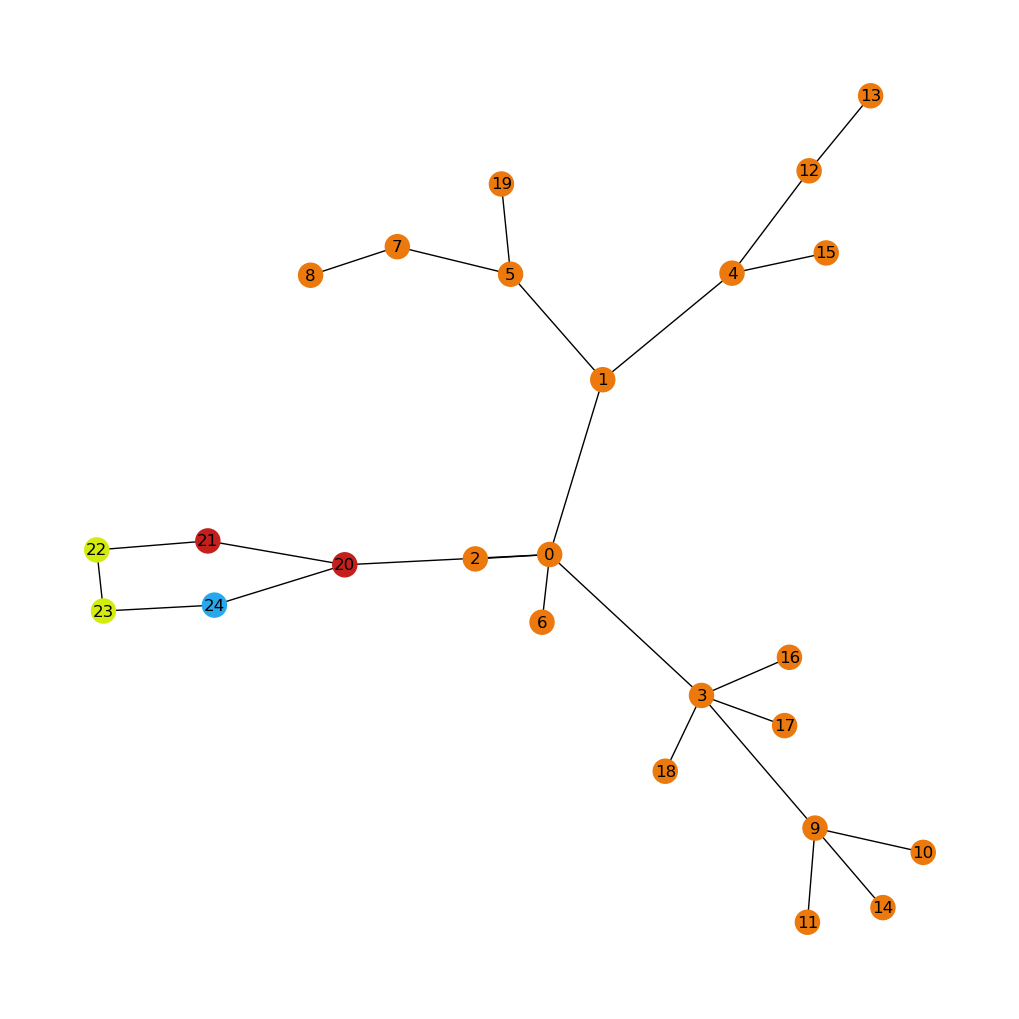

-----------Original Graph with edge weights-----------


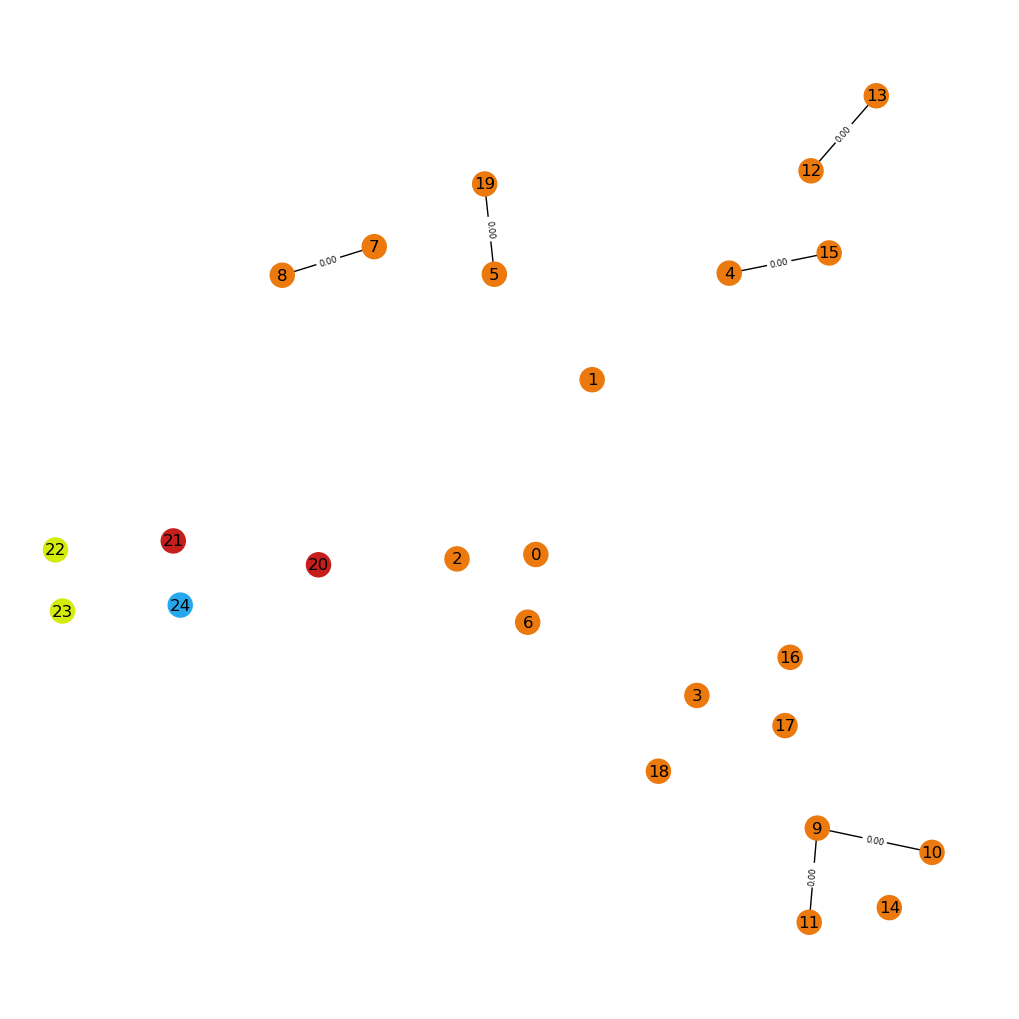

-----------------Explanation Graph-----------------


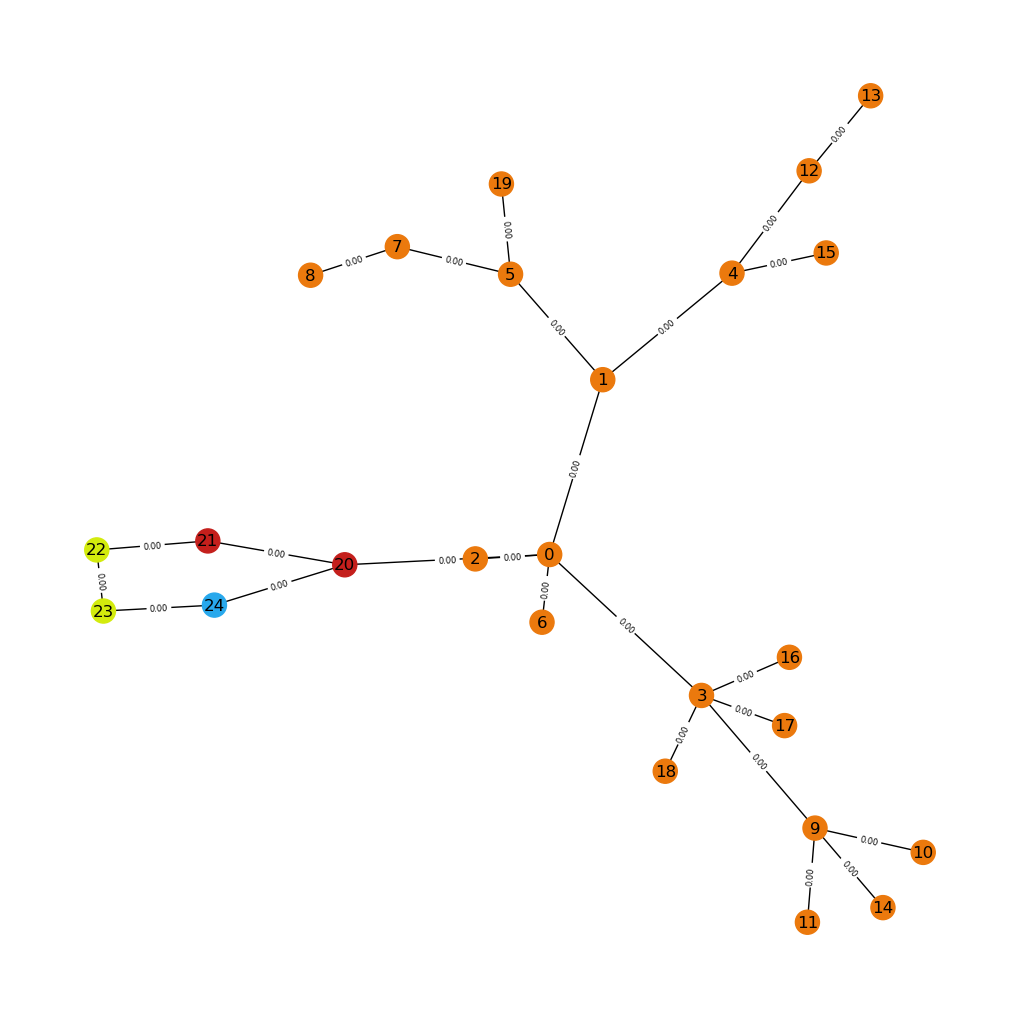

-----------------Ground truth Graph-----------------


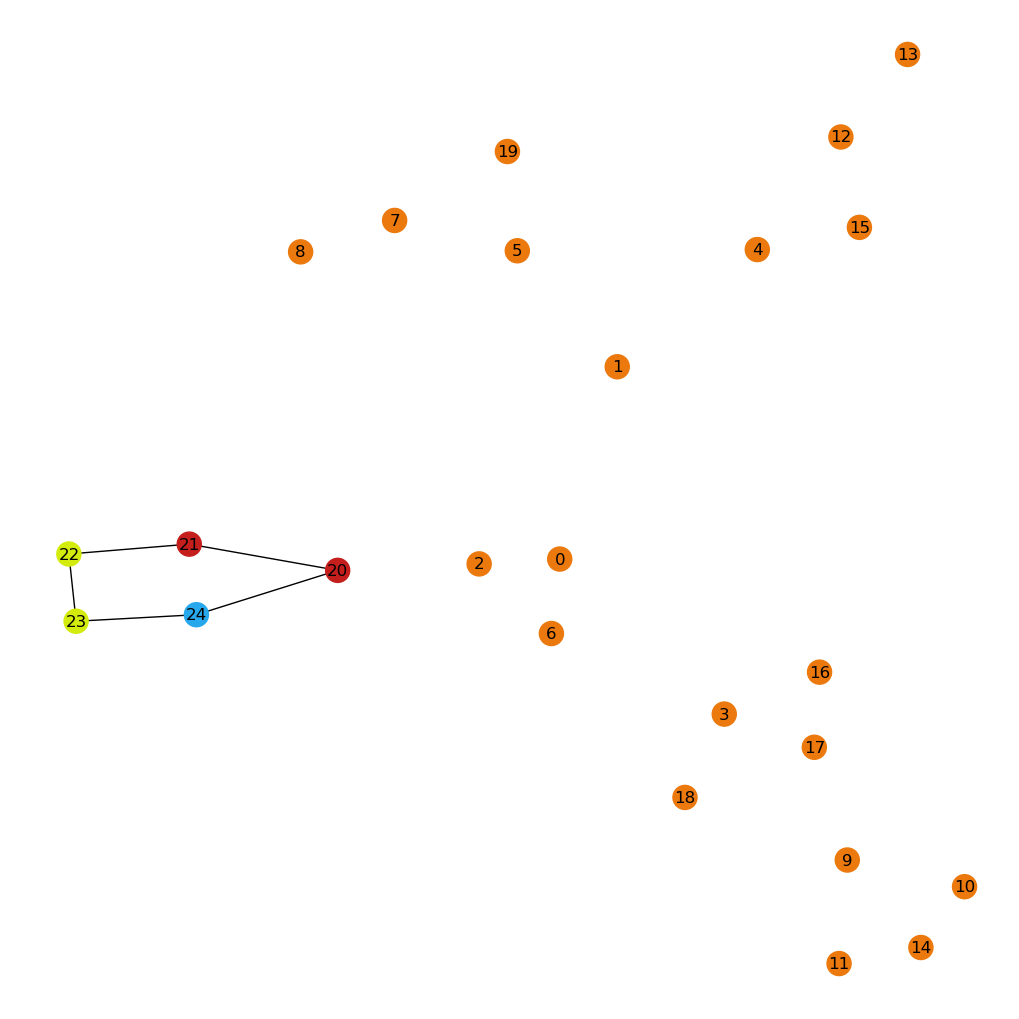

Mean AUC for evaluation: 0.59801126369587


In [4]:
importlib.reload(evaluation)

auc = evaluation.evaluate(datasetName=dataset, mlp=mlp, downstreamTask=downstreamTask)

print(f"Mean AUC for evaluation: {auc}")

In [8]:
import wandb
wandb.finish()

In [10]:
import utils
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [14]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [16]:
k = 5

data1 = data

printLoader = DataLoader([data1], 1, False)

temperature = 1

In [17]:
mlp.eval()
downstreamTask.eval()

w_ij = mlp.forward(downstreamTask, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4110x120 and 180x64)

In [18]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [23]:
import random
import evaluation
from torch_geometric.utils import k_hop_subgraph

motifNodesOriginal = [i for i in range(400,700,5)]

randomAUCNode = random.choice(motifNodesOriginal)
currentAUC = randomAUCNode

AUC of ROC: 0.9920886158943176
BinaryAUROC: 0.9920886075949367
roc_auc_score: 0.9920886075949368
0.9920886075949368


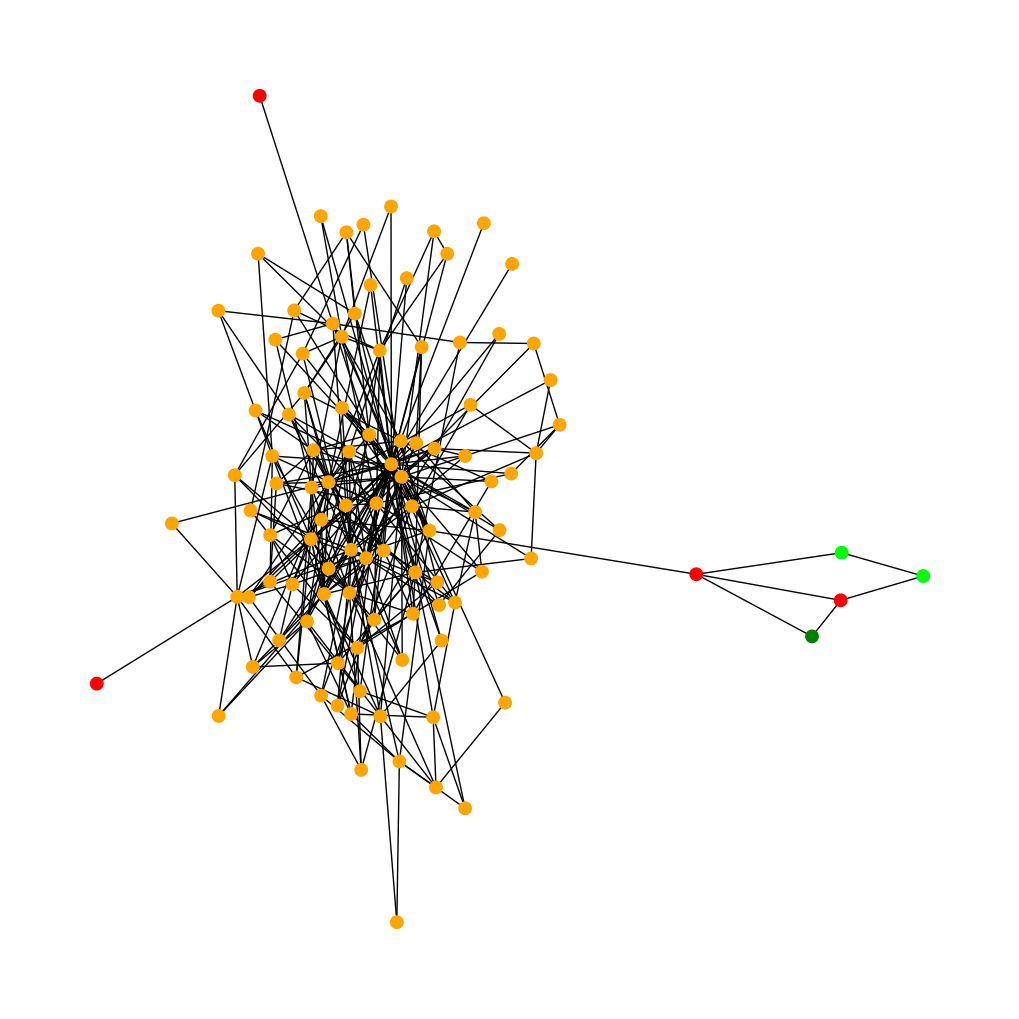

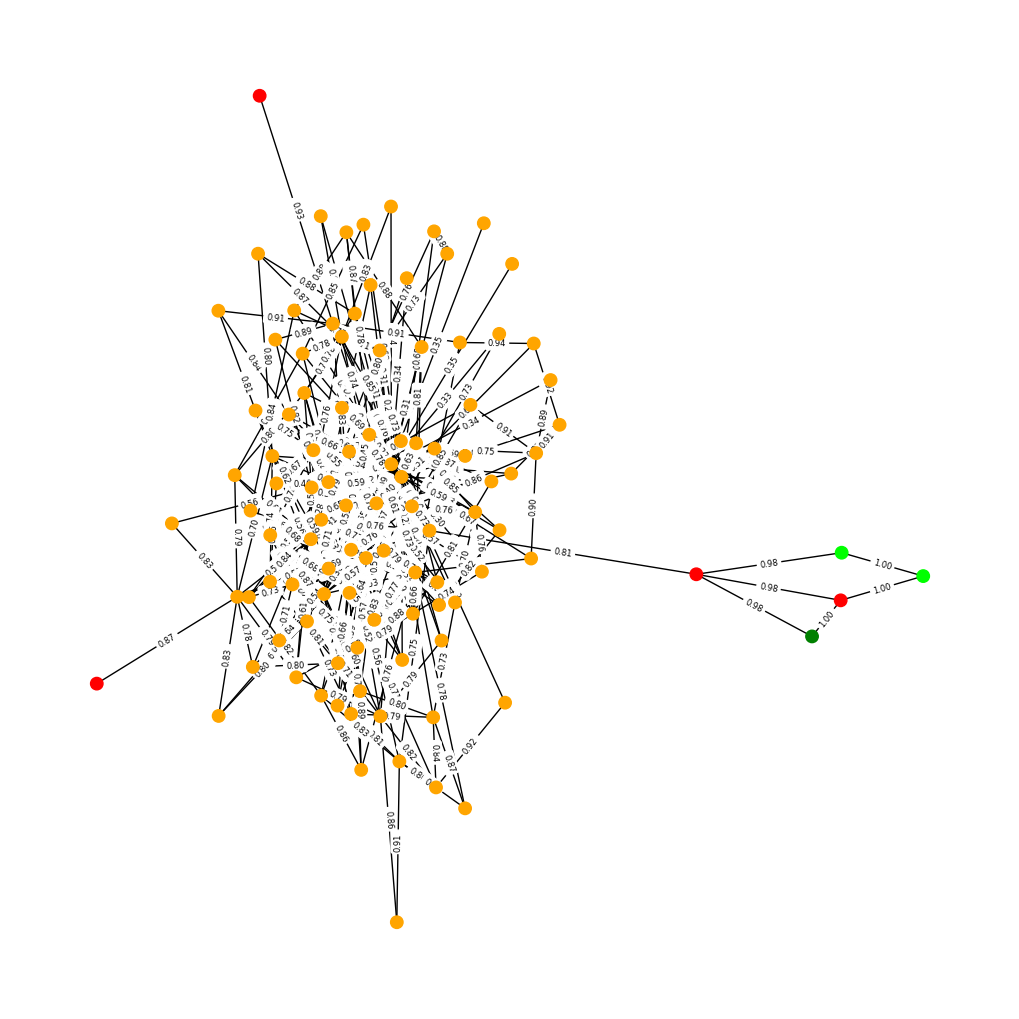

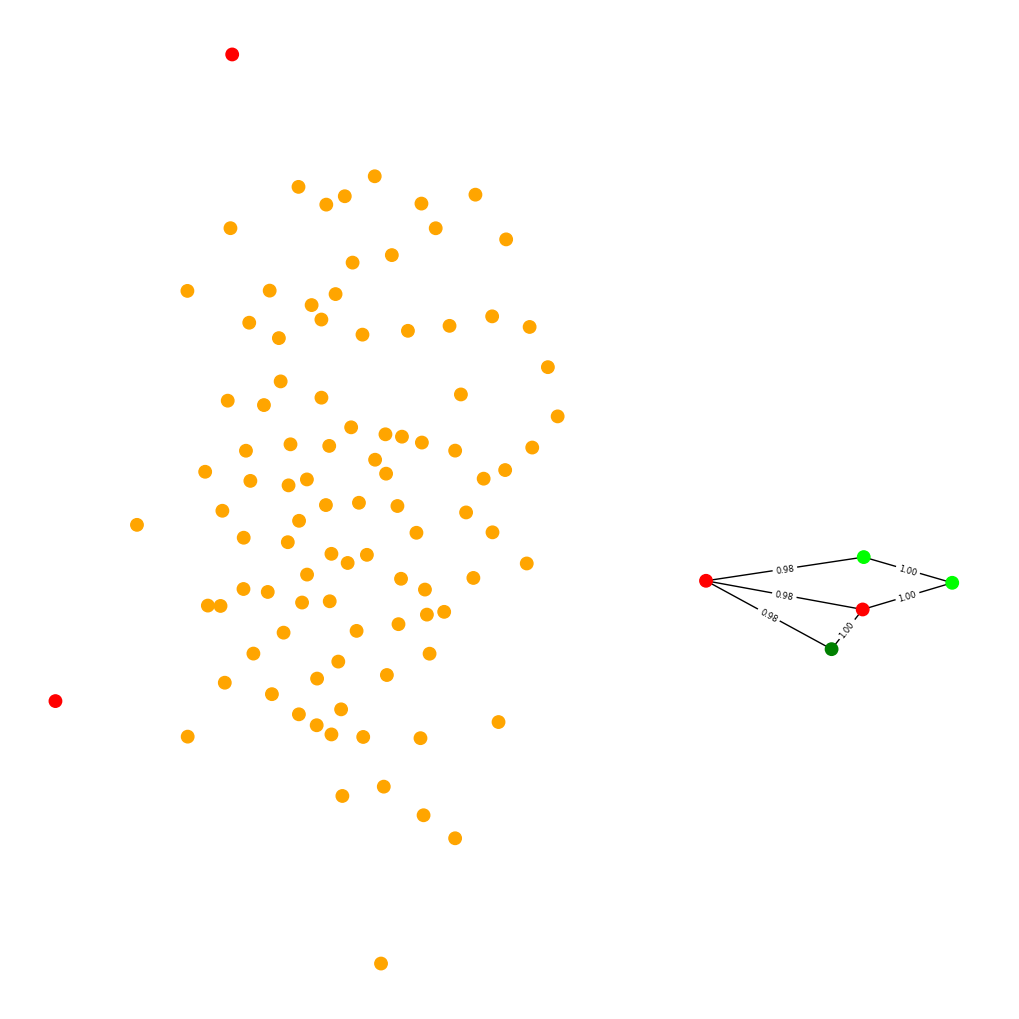

In [24]:
k = 6

mlp.eval()
downstreamTask.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]

#print(data.edge_index)

print(evaluation.evaluateNodeExplainerAUC(mlp, downstreamTask, data, data.edge_index, currentAUC, data.gt, k=k))

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotGraphAll(G_hop)




w_ij = mlp.forward(downstreamTask, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

#print(torch.unique(w_ij))
edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


GraphSampled = Data(x=G_hop.x, edge_index=G_hop.edge_index, y=G_hop.y, edge_attr=edge_ij.detach())

pos = utils.plotGraphAll(GraphSampled, pos, edge_weights=True)


# Print topK edges
k = k * 2 if len(w_ij) >= k*2 else len(w_ij)
_, top_k_indices = torch.topk(edge_ij, k=k, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, y=G_hop.y, edge_attr=weights_masked)

pos1 = utils.plotGraphAll(GtopK, pos=pos, color_map=None, edge_weights=True)